In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import os
from google.cloud import storage

%load_ext google.cloud.bigquery

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'project-key.json'

In [3]:
%%bigquery usairportDf

SELECT * FROM `bigquery-public-data.faa.us_airports`
WHERE state_abbreviation is not NULL and iap_exists = true
AND airport_use = 'Public'
AND name LIKE '%Intl'
ORDER BY state_abbreviation 
LIMIT 1000

In [4]:
usairportDf.columns

Index(['object_id', 'global_id', 'faa_identifier', 'name', 'longitude',
       'latitude', 'airport_geom', 'elevation', 'icao_id', 'airport_type',
       'service_city', 'state_abbreviation', 'country', 'oper_status',
       'airport_use', 'iap_exists', 'dod_hiflip', 'far_91', 'far_93',
       'mil_code', 'airspace_analysis', 'us_high', 'us_low', 'ak_high',
       'ak_low', 'us_area', 'pacific'],
      dtype='object')

In [5]:
def get_int_flights(df):
    df = df [(~df["origin"].isna()) & (~df["destination"].isna())]
    df = df[(~df["origin"].isin(usairportDf.icao_id.unique()))]
    df = df.merge(usairportDf[["icao_id", "state_abbreviation"]], left_on="destination", right_on="icao_id", how="inner")
    df["firstseen"] = pd.to_datetime(df["firstseen"])
    df["lastseen"] = pd.to_datetime(df["lastseen"])
    df["day"] = pd.to_datetime(df["day"])
    df["duration"] = (df["lastseen"] - df["firstseen"]).dt.seconds / 3600
    df = df[df["duration"] >= 5]
    return df

In [7]:
janFlightsDf = pd.read_csv("./data/raw/flightlist_20200101_20200131.csv.gz")
janFlightsDf.head()

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day
0,SVA816,NaN,710064,HZ-AK24,B77W,NaN,NaN,2019-12-31 00:19:47+00:00,2020-01-01 13:27:28+00:00,2020-01-01 00:00:00+00:00
1,THY183,NaN,4ba9c1,TC-JNA,A332,NaN,LTBW,2019-12-31 00:25:26+00:00,2020-01-01 07:48:41+00:00,2020-01-01 00:00:00+00:00
2,CES738,MU738,781418,NaN,NaN,YMML,YSSY,2019-12-31 01:08:54+00:00,2020-01-01 01:45:29+00:00,2020-01-01 00:00:00+00:00
3,CES771,MU771,781858,NaN,NaN,YSSY,EHAM,2019-12-31 01:29:25+00:00,2020-01-01 04:08:28+00:00,2020-01-01 00:00:00+00:00
4,HAL5,HA5,a455ea,N379HA,A332,KLAS,NaN,2019-12-31 02:23:05+00:00,2020-01-01 08:52:18+00:00,2020-01-01 00:00:00+00:00


In [8]:
janIntDf = get_int_flights(janFlightsDf)

In [9]:
del janFlightsDf

In [10]:
febFlightsDf = pd.read_csv("./data/raw/flightlist_20200201_20200229.csv.gz")
febFlightsDf.head()

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day
0,CES297,MU297,780d9e,B-2022,B77W,NaN,KJFK,2020-01-31 00:00:08+00:00,2020-02-01 02:11:45+00:00,2020-02-01 00:00:00+00:00
1,LAN576,LA576,e80214,CC-BGA,B789,NaN,SKBO,2020-01-31 00:00:08+00:00,2020-02-01 00:03:33+00:00,2020-02-01 00:00:00+00:00
2,SVA870,NaN,7100bf,HZ-AK31,B77W,NaN,RPLL,2020-01-31 00:00:11+00:00,2020-02-01 08:45:10+00:00,2020-02-01 00:00:00+00:00
3,CBJ429,NaN,78131e,NaN,NaN,NaN,LPAR,2020-01-31 01:16:27+00:00,2020-02-01 06:28:50+00:00,2020-02-01 00:00:00+00:00
4,KQA304,KQ304,04c14a,5Y-CYD,B738,FAOR,OMDB,2020-01-31 01:18:57+00:00,2020-02-01 01:44:59+00:00,2020-02-01 00:00:00+00:00


In [11]:
febIntDf = get_int_flights(febFlightsDf)

In [12]:
del febFlightsDf
febIntDf.head()

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,icao_id,state_abbreviation,duration
0,CPA866,NaN,780abb,B-LRP,A359,VHHH,KIAD,2020-01-31 10:04:33,2020-02-01 00:34:47,2020-02-01,KIAD,DC,14.503889
1,CCA962,CA962,78076e,B-2088,B77W,EDDM,KIAD,2020-01-31 11:23:41,2020-02-01 17:59:52,2020-02-01,KIAD,DC,6.603056
2,MSR981,MS981,0101e0,NaN,NaN,OMDB,KIAD,2020-01-31 12:41:40,2020-02-01 09:48:27,2020-02-01,KIAD,DC,21.113056
3,OAE703,NaN,a506da,N423AX,B763,LRBS,KIAD,2020-01-31 13:16:47,2020-02-01 00:10:11,2020-02-01,KIAD,DC,10.890000
4,UAL933,UA933,a75103,N57016,B772,EDDF,KIAD,2020-01-31 16:15:35,2020-02-01 00:40:23,2020-02-01,KIAD,DC,8.413333


In [13]:
marFlightsDf = pd.read_csv("./data/raw/flightlist_20200301_20200331.csv.gz")
marFlightsDf.head()

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day
0,SVA824,SV824,710058,HZ-AK16,B77W,OERK,NaN,2020-02-29 00:03:24+00:00,2020-03-01 02:56:13+00:00,2020-03-01 00:00:00+00:00
1,KTK111,NaN,42444a,NaN,NaN,UUWW,UUWW,2020-02-29 00:41:10+00:00,2020-03-01 02:46:51+00:00,2020-03-01 00:00:00+00:00
2,SVA870,NaN,7100c0,HZ-AK32,B77W,NaN,RPLL,2020-02-29 00:49:11+00:00,2020-03-01 07:39:58+00:00,2020-03-01 00:00:00+00:00
3,QFA64,QF64,7c4778,VH-OEI,B744,YSSY,YSSY,2020-02-29 01:00:11+00:00,2020-03-01 04:39:30+00:00,2020-03-01 00:00:00+00:00
4,LAN602,LA602,e80444,CC-BGC,B789,KMIA,KLAX,2020-02-29 01:12:29+00:00,2020-03-01 14:28:58+00:00,2020-03-01 00:00:00+00:00


In [14]:
marIntDf = get_int_flights(marFlightsDf)

In [15]:
del marFlightsDf
marIntDf.head()

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,icao_id,state_abbreviation,duration
0,SIA7194,NaN,76cccf,9V-SFO,B744,YSSY,KATL,2020-02-29 05:44:56,2020-03-01 04:04:59,2020-03-01,KATL,GA,22.334167
1,DAL1802,NaN,a16ff1,N192DN,B763,LFPG,KATL,2020-02-29 09:57:34,2020-03-01 01:47:09,2020-03-01,KATL,GA,15.826389
2,DAL26,DL26,a65bb7,N509DN,NaN,RKSI,KATL,2020-02-29 11:09:34,2020-03-01 00:03:19,2020-03-01,KATL,GA,12.895833
3,DAL85,DL85,ab8fd0,NaN,NaN,LFPG,KATL,2020-02-29 15:08:09,2020-03-01 00:06:10,2020-03-01,KATL,GA,8.966944
4,GEC8176,LH8176,3c70c4,D-ALFD,B77L,EDDF,KATL,2020-02-29 15:29:47,2020-03-01 00:31:08,2020-03-01,KATL,GA,9.022500


In [16]:
aprFlightsDf = pd.read_csv("./data/raw/flightlist_20200401_20200430.csv.gz")
aprFlightsDf.head()

,Unnamed: 0,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day
0,0,AUA1028,NaN,440081,OE-LPD,B772,YSSY,LOWW,2020-03-31 03:29:15+00:00,2020-04-01 00:41:43+00:00,2020-04-01 00:00:00+00:00
1,1,CSN472,CZ472,7807bb,B-2080,B77L,KLAX,PANC,2020-03-31 03:51:37+00:00,2020-04-01 07:09:16+00:00,2020-04-01 00:00:00+00:00
2,2,CSN461,CZ461,780da8,B-2026,B77L,KLAX,EDDF,2020-03-31 07:15:52+00:00,2020-04-01 12:02:53+00:00,2020-04-01 00:00:00+00:00
3,3,UPS32,5X32,a777b8,N580UP,B744,KSDF,YSSY,2020-03-31 08:17:12+00:00,2020-04-01 04:34:55+00:00,2020-04-01 00:00:00+00:00
4,4,ANA179,NH179,86d682,JA828A,B788,NaN,NaN,2020-03-31 09:28:46+00:00,2020-04-01 05:05:28+00:00,2020-04-01 00:00:00+00:00


In [17]:
aprIntDf = get_int_flights(aprFlightsDf)
del aprFlightsDf
aprIntDf.head()

,Unnamed: 0,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,icao_id,state_abbreviation,duration
0,16,UAL2793,NaN,a1cb0f,N2142U,B77W,VHHH,KORD,2020-03-31 13:16:55,2020-04-01 03:07:25,2020-04-01,KORD,IL,13.841667
1,96,LOT8507,LO8507,48ae21,SP-LSB,B789,EPWA,KORD,2020-03-31 15:11:16,2020-04-01 01:01:52,2020-04-01,KORD,IL,9.843333
2,88,GEC8188,LH8188,3c7064,D-ALCD,MD11,EDDF,KORD,2020-03-31 18:00:50,2020-04-01 02:27:52,2020-04-01,KORD,IL,8.450556
3,194,QTR8141,NaN,06a141,A7-BFH,B77L,EHAM,KORD,2020-03-31 20:15:25,2020-04-01 04:22:27,2020-04-01,KORD,IL,8.117222
20,6875,THY6589,NaN,4bb154,TC-LJT,B77L,LTBA,KORD,2020-04-01 02:38:19,2020-04-01 13:16:55,2020-04-01,KORD,IL,10.643333


In [18]:
allFlights = pd.concat([janIntDf, febIntDf, marIntDf, aprIntDf], sort=False)
# allFlights = allFlights.drop_duplicates()
print(allFlights.shape)
allFlights.head()

(42916, 14)


,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,icao_id,state_abbreviation,duration,Unnamed: 0
0,CPA812,NaN,780212,B-KPF,B77W,VHHH,KBOS,2019-12-31 10:27:04,2020-01-01 01:08:25,2020-01-01,KBOS,MA,14.689167,NaN
1,SWR52,NaN,4b1903,HB-JMH,A343,LSZH,KBOS,2019-12-31 16:32:15,2020-01-01 00:41:24,2020-01-01,KBOS,MA,8.152500,NaN
2,UAL2795,UA2795,a2a915,N27015,B772,EHAM,KBOS,2019-12-31 17:42:44,2020-01-01 00:49:41,2020-01-01,KBOS,MA,7.115833,NaN
3,EJA209,NaN,a1b4e1,N209QS,CL65,KSDL,KBOS,2019-12-31 18:05:15,2020-01-01 01:46:28,2020-01-01,KBOS,MA,7.686944,NaN
4,BAW239,BA239,40058b,G-ZZZB,B772,EGLL,KBOS,2019-12-31 19:33:23,2020-01-01 02:24:59,2020-01-01,KBOS,MA,6.860000,NaN


In [19]:
aggFlights = allFlights.groupby(["state_abbreviation", "day"])["destination"].count().reset_index().sort_values(by=["day"])

In [20]:
aggFlights["week"] = aggFlights["day"].dt.week
aggFlights = aggFlights.groupby(["state_abbreviation", "week"]).agg({'day':'min', 'destination':'sum'}).reset_index()
aggFlights

,state_abbreviation,week,day,destination
0,AK,1,2020-01-01,100
1,AK,2,2020-01-06,148
2,AK,3,2020-01-13,160
3,AK,4,2020-01-20,120
4,AK,5,2020-01-27,77
5,AK,6,2020-02-03,90
6,AK,7,2020-02-10,109
7,AK,8,2020-02-17,122
8,AK,9,2020-02-24,150
9,AK,10,2020-03-02,221


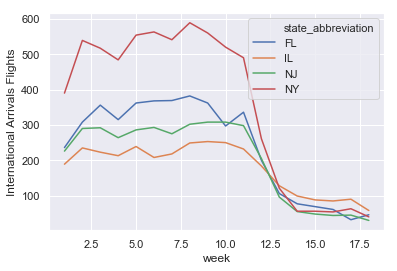

In [21]:
sns.lineplot(x="week", y="destination", data=aggFlights[aggFlights.state_abbreviation.isin(["NY", "FL", "NJ", "IL"])], hue="state_abbreviation")
plt.ylabel("International Arrivals Flights")
plt.show()

In [22]:
aggFlights.to_csv("data/aggregatedFlights.csv", index=False)